# Inference with DeepSD models

This notebook runs inference with DeepSD models trained using `deepsd_model_train.ipynb`. Here, it is assumed that the stacked model are stored on Azure with paths conforming to `stacked_model_path` and `output_node_name` templates defined in `deepsd.py`. 

The input data for inference are: 
1. the interpolated, normalized GCM data (i.e. z-score by the historical period of GCM), 
2. elevation data of all resolutions within the stacked model. 

Different GCMs are bilinearly interpolated to either 2 degree or 1 degree, before being fed into the DeepSD model (see `deepsd_data_prep.ipynb` for more details about how we determine the initial resolutions. The input data are maps of the entire spatial domain instead of patches as in training. 

Due to memory constraints, model inference is performed and saved in batches. Note that the inference code as is *does not* look for existing data. Thus, running that block of code is time consuming and will overwrite previously inferenced data. 

The raw output from DeepSD models are the normalized values. We then use the mean and standard deviation of historical observation data to restore the output. This step can be viewed as a bias correction step. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import xarray as xr
import xesmf as xe
import intake
import dask
import fsspec
import xbatcher
import os
import matplotlib.pyplot as plt
import time
import tensorflow_io

tf.compat.v1.disable_eager_execution()

2022-02-02 20:29:40.217193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-02 20:29:40.217240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
fs = fsspec.get_filesystem_class('az')(
    account_name='carbonplan', account_key=os.environ['TF_AZURE_STORAGE_KEY']
)

In [25]:
# determine which GCM/params to run 
gcm = 'CanESM5'
scenario = 'ssp370'

# variable to predict on 
var = 'pr'

# the historical period used for normalization 
historical_period_start = '1981'
historical_period_end = '2010'

# the inference period, can overlap with historical period 
inference_period_start = '1850'
inference_period_end = '2014'

In [26]:
from cmip6_downscaling.data.cmip import get_gcm, load_cmip
from cmip6_downscaling.data.observations import get_obs
from cmip6_downscaling.methods.deepsd import bilinear_interpolate, starting_resolutions, EPSILON, stacked_model_path, output_node_name, res_to_str
from cmip6_downscaling.workflows.utils import lon_to_180
from cmip6_downscaling.methods.deepsd import get_elevation_data, normalize, build_grid_spec


In [27]:
def get_normalized_gcm_data(
    gcm, 
    scenario, 
    var, 
    historical_period_start, 
    historical_period_end, 
    inference_period_start, 
    inference_period_end
):
    # load all gcm data for the gcm/scenario/var requested 
    historical_gcm = load_cmip(
        activity_ids='CMIP',
        experiment_ids='historical',
        source_ids=gcm,
        variable_ids=[var],
        return_type='xr',
    )
    
    future_gcm = load_cmip(
        activity_ids='ScenarioMIP',
        experiment_ids=scenario,
        source_ids=gcm,
        variable_ids=[var],
        return_type='xr',
    )
    # concat and convert to 180 degrees 
    ds_gcm = xr.combine_by_coords([historical_gcm, future_gcm], combine_attrs='drop_conflicts')
    ds_gcm = lon_to_180(ds_gcm)
    
    # subset to the period of interest 
    historical_gcm = ds_gcm.sel(time=slice(historical_period_start, historical_period_end))
    inference_gcm = ds_gcm.sel(time=slice(inference_period_start, inference_period_end))
    
    # calculate the historical average and mean for z scoring
    historical_gcm_mean = historical_gcm.mean(dim='time').compute()
    historical_gcm_std  = historical_gcm.std(dim='time').compute()

    # bilinearly interpolated the inference data and the historical mean/std to the starting resolution 
    # this is 2.0 degrees for some GCMs and 1.0 degrees for others 
    starting_resolution = starting_resolutions[gcm]
    inference_gcm = bilinear_interpolate(output_degree=starting_resolution, ds=inference_gcm)
    historical_gcm_mean = bilinear_interpolate(output_degree=starting_resolution, ds=historical_gcm_mean)
    historical_gcm_std = bilinear_interpolate(output_degree=starting_resolution, ds=historical_gcm_std)

    # calculate zscore 
    return ((inference_gcm - historical_gcm_mean) / (historical_gcm_std + EPSILON))

In [28]:
# find all the output resolution for each SRCNN in the stacked model according to the starting resolution of the GCM of interest 
if starting_resolutions[gcm] == 2.0:
    output_resolutions = [0.25, 0.5, 1.0]
elif starting_resolutions[gcm] == 1.0:
    output_resolutions = [0.25, 0.5]
else:
    raise Error('needs to be either 2.0 or 1.0') 

# make sure this is from low res to high res 
output_resolutions = sorted(output_resolutions, reverse=True)

# get elevations at all relevant resolutions 
elevs = []
for output_res in output_resolutions:
    elev = get_elevation_data(output_res)
    elev_norm = normalize(ds=elev, dims=['lat', 'lon'], epsilon=EPSILON).elevation.values
    elevs.append(tf.constant(elev_norm[np.newaxis, :, :, np.newaxis].astype(np.float32)))
    
input_map= {'elev_%i' % i: elevs[i] for i in range(len(output_resolutions))}

In [29]:
# now read in the frozen graph of the stacked model, set placeholder for x, constant for elevs
x = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 1))
input_map['lr_x'] = x

model_path = stacked_model_path.format(var=var, starting_resolution=res_to_str(starting_resolutions[gcm]))
output_node = output_node_name.format(var=var)

with tf.io.gfile.GFile(model_path, "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

    y, = tf.import_graph_def(
        graph_def,
        input_map=input_map,
        return_elements=[output_node],
        name='deepsd',
        op_dict=None,
        producer_op_list=None
    )

/tmp/ipykernel_3616/3497222905.py:10: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  graph_def.ParseFromString(f.read())


In [30]:
# now read the gcm model data 
gcm_norm = get_normalized_gcm_data(
    gcm, 
    scenario, 
    var, 
    historical_period_start, 
    historical_period_end, 
    inference_period_start, 
    inference_period_end
)
gcm_norm = gcm_norm.transpose('time', 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

In [31]:
def initialize_empty_dataset(lats, lons, times, output_path, var):
    # if zarr already exists then just return the path and don't touch it since
    # it will delete the existing store if you try to initialize again
    if fs.exists(output_path):
        pass
    
    # if not then make an empty dataset
    else:
        ds = xr.DataArray(
            np.empty(shape=(len(times), len(lats), len(lons))),
            dims=['time', 'lat', 'lon'],
            coords=[times, lats, lons],
        )
        ds = ds.to_dataset(name=var)

        mapper = fsspec.get_mapper(output_path)
        ds.astype('float32').to_zarr(mapper, mode='w', compute=False)

In [32]:
# downscale data in batches and save to the output path  
batch_size = 5000
n = len(gcm_norm.time.values)

print('getting elevation')
output_path = f'az://flow-outputs/results/deepsd/{gcm}_{scenario}_{historical_period_start}_{historical_period_end}_{inference_period_start}_{inference_period_end}_{var}_norm.zarr'
# use the 0.25 degree resolution as the template for lat/lon grid 
elev_hr = get_elevation_data(0.25)

print('initializing')
initialize_empty_dataset(
    lats=elev_hr.lat.values, 
    lons=elev_hr.lon.values, 
    times=gcm_norm.time.values, 
    output_path=output_path, 
    var=var)

print('batching')
for start in range(0, n, batch_size):
    stop = min(start + batch_size, n)
    print(start, stop)

    X = gcm_norm.isel(time=slice(start, stop))[var].values

    downscaled_batch = np.empty(shape=(stop-start, len(elev_hr.lat.values), len(elev_hr.lon.values)))
    with tf.compat.v1.Session() as sess:
        for i in range(X.shape[0]):
            _x = X[i][np.newaxis, :, :, np.newaxis]
            _y = sess.run(y, feed_dict={x: _x})
            downscaled_batch[i, :, :] = _y[0, :, :, 0]

    downscaled_batch = xr.DataArray(
        downscaled_batch,
        dims=['time', 'lat', 'lon'],
        coords=[gcm_norm.isel(time=slice(start, stop)).time.values,
                elev_hr.lat.values,
                elev_hr.lon.values]
    )
    
    region = {
        "lat": slice(0, len(elev_hr.lat.values)),
        'lon': slice(0, len(elev_hr.lon.values)),
        'time': slice(start, stop),
    }

    store = fsspec.get_mapper(output_path)
    task = downscaled_batch.to_dataset(name=var).to_zarr(
        store,
        mode='a',
        region=region,
        compute=False,
    )
    task.compute(retries=10)

getting elevation


In [33]:
store = fsspec.get_mapper(output_path)
downscaled_norm = xr.open_zarr(store)

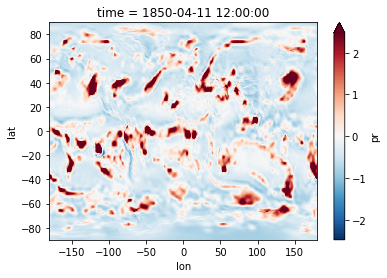

In [34]:
downscaled_norm.isel(time=100)[var].plot(robust=True)

In [35]:
downscaled_norm

,Array,Chunk
Bytes,232.61 GiB,14.87 MiB
Shape,"(60225, 720, 1440)","(1883, 23, 90)"
Count,16385 Tasks,16384 Chunks
Type,float32,numpy.ndarray


In [36]:
from cmip6_downscaling.methods.deepsd import get_obs_mean, get_obs_std

obs = 'ERA5'
variables = ['pr', 'tasmax', 'tasmin']
gcm_grid_spec = build_grid_spec(output_degree=0.25)

# note that this will error out if the mean/std isn't already saved because we're not providing a valid dataset into the function 
obs_mean = get_obs_mean(
    obs=obs,
    train_period_start=historical_period_start,
    train_period_end=historical_period_end,
    variables=variables,
    gcm_grid_spec=gcm_grid_spec)
    
obs_std = get_obs_std(
    obs=obs,
    train_period_start=historical_period_start,
    train_period_end=historical_period_end,
    variables=variables,
    gcm_grid_spec=gcm_grid_spec)

In [37]:
downscaled = (downscaled_norm * (obs_std[var] + EPSILON)) + obs_mean[var]
if var == 'pr':
    downscaled = downscaled.clip(min=0)

In [38]:
obs_template = get_obs(
    obs=obs,
    train_period_start='1980',
    train_period_end='1980',
    variables=[var]
).isel(time=0).load()

In [39]:
# go from 720x1440 -> 721x1440 
regridder = xe.Regridder(downscaled.chunk({'time': 1, 'lat': -1, 'lon': -1}), obs_template, "bilinear", extrap_method="nearest_s2d")
downscaled_regridded = regridder(downscaled.chunk({'time': 1, 'lat': -1, 'lon': -1})).astype('float32')

In [40]:
downscaled_regridded

<xarray.Dataset>
Dimensions:  (time: 60225, lat: 721, lon: 1440)
Coordinates:
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [41]:
store = fsspec.get_mapper(
    f'az://flow-outputs/results/deepsd/{gcm}_{scenario}_{historical_period_start}_{historical_period_end}_{inference_period_start}_{inference_period_end}_{var}.zarr')
downscaled_regridded.astype('float32').to_zarr(store, mode='w', consolidated=True)

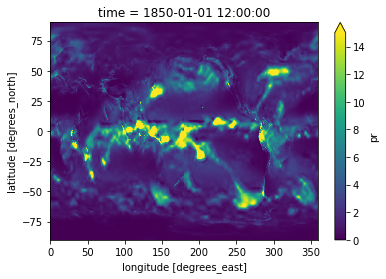

In [42]:
store = fsspec.get_mapper(
    f'az://flow-outputs/results/deepsd/{gcm}_{scenario}_{historical_period_start}_{historical_period_end}_{inference_period_start}_{inference_period_end}_{var}.zarr')
downscaled_regridded = xr.open_zarr(store)
downscaled_regridded[var].isel(time=0).plot(vmin=0, vmax=15)